In [1]:
import numpy as np
from numba import jit,cuda
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32
from matplotlib import pyplot as plt
import math,time
import scipy.ndimage.filters
from threading import Thread,Lock
from ipywidgets import Image, HBox
import ipywidgets as widgets
from ipycanvas import Canvas
import io




class Cleanup():
    """The purpose of this is to keep track of all the threads I run, and terminate
    them with reset or hard_reset."""
    def __init__(self):
        self.threads = []
    def add(self,*threads):
        """Keep a list of active threads"""
        for thread in threads:
            self.threads.append(thread)
    def reset(self):
        """Threads with a while loop terminate according to a variable called isalive.
        This will terminate all running threads, but raise an exception with threads 
        that have not started yet"""
        for t in self.threads:
            t.isalive=False
            t.join()
        self.threads=[]
    def hard_reset(self):
        """This makes sure all threads have been started then terminates them."""
        for a in self.threads:
            try:
                a.start()
            except:
                pass
        self.reset()
cleaner = Cleanup()

In [2]:
@cuda.jit
def fast_ising(grid,JB,mew,parity,rng_states,size):
    """Updates 1/4 of the grid by stochastically choosing points
    on a checkerboard grid and updating with boltzmann probability"""
    #find grid location
    i,j=cuda.grid(2)
    #get your first random number
    n = xoroshiro128p_uniform_float32(rng_states, i*size+j)
    #parity is 0 or 1, and tells you which half of the checkerboard to update
    #Instead of updating the entire checkerboard,  each position
    #is updated with probability 0.5
    if ((i+j)%2==parity and n < 0.5 and i<size and j<size):
        #sum the values of the nearest neighbors
        sum_=grid[i-1][j]+grid[i+1-size][j]+grid[i][j-1]+grid[i][j+1-size]
        #its grid*2-1 because I am using zero for spin down and 1 for spin up
        delta = 2.0 * (grid[i][j]*2-1)*(2*sum_-4+mew)
        #get our second random number
        n = xoroshiro128p_uniform_float32(rng_states, i*size+j)
        #update the cell according to the boltzmann distribution
        if (delta < 0 or 1-n < math.exp(-JB*delta)):
            grid[i][j]=1-grid[i][j]

In [3]:
@cuda.jit
def continuous_ising(grid,active,steps,JB,mew,rng_states,size):
    """Updates the grid by stochastically choosing points
    and updating with boltzmann probability"""
    
    #this runs async on each thread
    x,y=cuda.grid(2)
    idx=x*size+y
    for x in range(steps):
        #choose a random grid location  
        i=int(math.floor(xoroshiro128p_uniform_float32(rng_states, idx)* size))
        j=int(math.floor(xoroshiro128p_uniform_float32(rng_states, idx)* size))
        if i==size or j==size:continue
        #lock this grid position
        lock1=1-cuda.atomic.max(active[i],j,1)
        #threadfence to make sure other blocks know this is locked
        cuda.threadfence()
        #check to make sure none of the neighbours are locked
        lock2 = int(active[i-1][j]+active[i+1-size][j]+active[i][j-1]+active[i][j+1-size]==0)
        #check the spin of each neighbour
        sum_=grid[i-1][j]+grid[i+1-size][j]+grid[i][j-1]+grid[i][j+1-size]
        delta = 2.0 * (grid[i][j]*2-1)*(2*sum_-4+mew)
        #get a random number for our boltzmann update
        n = xoroshiro128p_uniform_float32(rng_states, idx)  
        #lock3 is our decision to perform the ising update according to the boltzmann distribution
        lock3=int(1-n < math.exp(-JB*delta))
        #update is zero if the thread or it's neighbours were already locked
        update=lock1*lock2*lock3*(1-2*grid[i][j])
        #add 0,1, or -1 depending on if the cell should be updated (boltzmann and locking)
        cuda.atomic.add(grid[i], j, update)
        cuda.threadfence()
        #make sure the update is visible to the other blocks
        cuda.atomic.add(active[i],j,-lock1)
        #unlock
        cuda.threadfence()
        #make sure the unlocking is visible to the other blocks

In [38]:
@cuda.jit
def upscale(inarr,outarr):
    """Simple upscaling function."""
    i,j=cuda.grid(2)
    iscale=outarr.shape[0]//inarr.shape[0]
    jscale=outarr.shape[1]//inarr.shape[1]
    outarr[i][j]=inarr[i//iscale][j//jscale]
class Render(Thread):
    def __init__(self, globalmem, canvas,dim=[512,512]):
        self.upscaled=np.zeros(dim)
        self.threads=(16,16)
        self.blocks=(int(np.ceil(dim[0] / 16)),int(np.ceil(dim[1] / 16)))
        self.grid_global_mem = globalmem
        self.canvas = canvas
        self.isalive=True
        super(Render, self).__init__()
    def run(self):
        while self.isalive:
            upscale[self.blocks,self.threads](self.grid_global_mem,self.upscaled)
            gridf=self.upscaled
            blue_channel = (1-gridf)*255
            red_channel = gridf*255
            green_channel = np.zeros_like(gridf)
            image_data = np.stack((red_channel, green_channel, blue_channel), axis=2)
            self.canvas.put_image_data(image_data, 0, 0)
            time.sleep(0.01)
            
            
class Ising(Thread):
    def __init__(self, N):
        #setup the lattice and helper data structures
        self.N=N
        self.grid=np.asarray(np.random.random([N,N])>0.5,dtype=np.int64)
        self.threadsperblock = (16, 16)#should end up a multiple of 32 I think
        blockspergrid_x = int(np.ceil(self.grid.shape[0] / self.threadsperblock[0]))
        blockspergrid_y = int(np.ceil(self.grid.shape[1] / self.threadsperblock[1]))
        self.blockspergrid = (blockspergrid_x, blockspergrid_y)
        self.blockalt=(min(blockspergrid_x//2,8), min(blockspergrid_y//2,8))
        self.isalive=True
        self.rng_states = create_xoroshiro128p_states(self.grid.size, seed=1)
        self.grid_global_mem = cuda.to_device(self.grid)
        self.JB=5
        self.mew=0
        self.rspeed=100
        self.act=cuda.to_device(np.zeros_like(self.grid,dtype=np.int32))
        super(Ising, self).__init__()
    def fps(self):
        """Gives the number of updates performed in one second"""
        iold = self.index
        time.sleep(1)
        return self.index-iold
    def run(self):
        """Run the ising updates on a thread"""
        self.index=0
        while self.isalive:
            self.index+=1
            if True:
                continuous_ising[self.blockalt, (16,16)](self.grid_global_mem,self.act,50,self.JB,self.mew,self.rng_states,self.N)
                #time.sleep(0.01)
            else:
                fast_ising[self.blockspergrid, self.threadsperblock](self.grid_global_mem,self.JB,self.mew,0,self.rng_states,self.N)
                fast_ising[self.blockspergrid, self.threadsperblock](self.grid_global_mem,self.JB,self.mew,1,self.rng_states,self.N)
                #time.sleep(0.001)
cleaner.hard_reset()    
model = Ising(128)
print(model.blockspergrid)
print(model.threadsperblock)
print(model.blockalt)
canvas = Canvas(width=512,height=512)
rend = Render(model.grid_global_mem,canvas,dim=[512,512])
cleaner.add(model,rend)
model.start()
rend.start()


def func(Beta,mew):
    model.JB=Beta
    model.mew=mew
    
plswork = widgets.Layout(
    width='50%'
)
    
x = widgets.FloatSlider(min=0,max=2,value=0.4407,step=0.001,layout=plswork)
x.style.handle_color = 'lightblue'
y = widgets.FloatSlider(min=-2,max=2,step=0.001,layout=plswork)
widgets.interact(func,Beta=x,mew=y)

canvas

(8, 8)
(16, 16)
(4, 4)


interactive(children=(FloatSlider(value=0.4407, description='Beta', layout=Layout(width='50%'), max=2.0, step=…

Canvas(height=512, width=512)

In [39]:
model.JB=2
print(model.fps())
cleaner.hard_reset()

3947


0.029919862747192383


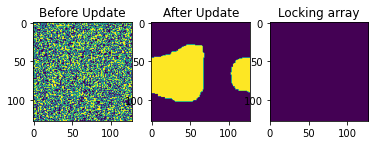

Max value in grid (should be 0 or 1): 1
Max value in locking array (should be 0): 0.0


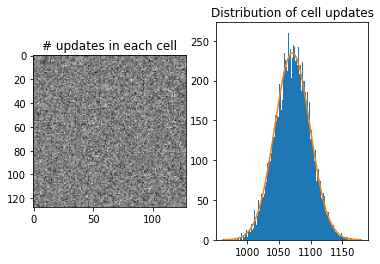

0.2142 (0.0056) Updates per cell per step


In [6]:
@cuda.jit
def debugger(grid,active,debug,steps,JB,mew,rng_states,size):
    """Updates the grid by stochastically choosing points
    and updating with boltzmann probability. This was used to debug the code,
    but now that it works, it just stores the number of updates to each cell
    in debug."""
    
    #this runs async on each thread
    x,y=cuda.grid(2)
    idx=x*size+y
    for x in range(steps):
        #choose a random grid location  
        i=int(math.floor(xoroshiro128p_uniform_float32(rng_states, idx)* size))
        j=int(math.floor(xoroshiro128p_uniform_float32(rng_states, idx)* size))
        if i==size or j==size:continue
        lock1=1-cuda.atomic.max(active[i],j,1)
        cuda.threadfence()
        lock2 = int(active[i-1][j]+active[i+1-size][j]+active[i][j-1]+active[i][j+1-size]==0)
        sum_=grid[i-1][j]+grid[i+1-size][j]+grid[i][j-1]+grid[i][j+1-size]
        delta = 2.0 * (grid[i][j]*2-1)*(2*sum_-4+mew)
        n = xoroshiro128p_uniform_float32(rng_states, idx)        
        lock3=int(1-n < math.exp(-JB*delta))
        update=lock1*lock2*lock3*(1-2*grid[i][j])
        cuda.atomic.add(grid[i], j, update)
        cuda.threadfence()
        cuda.atomic.add(active[i],j,-lock1)
        cuda.atomic.add(debug[i],j,lock1)
        cuda.threadfence()


#setting up the lattice            
grid=np.array(np.random.random([128,128])>0.5,dtype=np.int32)
act=cuda.to_device(np.zeros_like(grid,dtype=np.int32))
debug=cuda.to_device(np.zeros_like(grid,dtype=np.int32))


fig, axs = plt.subplots(1,3)
#fig.suptitle('Ising Grid')

axs[0].imshow(grid)
axs[0].set_title("Before Update")
rngs=create_xoroshiro128p_states(grid.size, seed=1)
#dummy call to compile
debugger[(4,4), (16,16)](grid,act,debug,0,0,0,rngs,128)
Nsteps=5000
t=time.time()
debugger[(4,4), (16,16)](grid,act,debug,Nsteps,5,0,rngs,128)
print(time.time()-t)
axs[1].imshow(grid)
axs[1].set_title("After Update")

axs[2].imshow(act)
axs[2].set_title("Locking array")
plt.show()
print("Max value in grid (should be 0 or 1):",np.max(grid))
print("Max value in locking array (should be 0):",np.max(act))

#Getting some stats on the number of cell updates per call

fig, axs = plt.subplots(1,2)
axs[0].imshow(debug,cmap='binary')
axs[0].set_title("# updates in each cell")
axs[1].hist(debug.copy_to_host().reshape(debug.size),int(np.max(debug)-np.min(debug)))
axs[1].set_title("Distribution of cell updates")


normalized = np.array(debug.copy_to_host(),dtype=np.float32)
avg=np.sum(normalized)/grid.size
stdv=(np.sum((normalized-avg)**2)/grid.size)**0.5
xs=np.linspace(np.min(debug),np.max(debug),int(np.max(debug)-np.min(debug)))
ys=128**2/stdv/np.sqrt(2*np.pi)*np.exp(-0.5*((xs-avg)/stdv)**2)
axs[1].plot(xs,ys)
plt.show()

print("%.4f (%.4f) Updates per cell per step"%(avg/Nsteps,stdv/Nsteps))

In [24]:
@cuda.jit
def E(grid,store,idx,s):
    """Total energy of the lattice"""
    i,j=cuda.grid(2)
    if i>=s or j>=s:return
    v=-2*(grid[i][j]*2-1)*(grid[i-1][j]+grid[i][j-1]-1)
    cuda.atomic.add(store,idx,v)
    
@cuda.jit
def corr(grid,ref,exy,ex,idx,s):
    i,j=cuda.grid(2)
    if i>=s or j>=s:return
    if idx==0:
        ref[i][j]=grid[i][j]
        
    a=ref[i][j]*2-1
    b=grid[i][j]*2-1
    cuda.atomic.add(exy,idx,a*b)
    cuda.atomic.add(ex,0,b)
    
@cuda.jit
def zero_1d(arr,L):
    i=cuda.grid(1)
    if i<L:
        arr[i]=0
    
def H(arr):
    s=0
    w=len(arr)
    h=len(arr[0])
    for x in range(w):
        for y in range(h):
            s-=arr[x][y]*arr[x][y-1]
            s-=arr[x][y]*arr[x-1][y]
    return s

grid=np.random.random([128,128])>0.5
store=np.zeros([1])
E[(8,8),(16,16)](grid,store,0,128)

print(store[0],H(2*grid-1))



-12.0 -12


In [29]:
#Here I am going to verify the two ising update functions with the analytical solution.

def partition(L,B):
    """Exact partition function for the ising model"""
    c = lambda r: np.cosh(2*B)/np.tanh(2*B)-np.cos(r*np.pi/L)
    y = lambda r: (2*B+np.log(np.tanh(B)) if r==0 else np.log(c(r)+(c(r)**2-1)**0.5))
    Z1=np.prod([2*np.cosh(L/2*y(2*r+1)) for r in range(L)])
    Z2=np.prod([2*np.sinh(L/2*y(2*r+1)) for r in range(L)])
    Z3=np.prod([2*np.cosh(L/2*y(2*r)) for r in range(L)])
    Z4=np.prod([2*np.sinh(L/2*y(2*r)) for r in range(L)])
    print(Z1,Z2,Z3,Z4)
    return 0.5*(2*np.sinh(2*B))**(0.5*L**2)*(Z1+Z2+Z3+Z4)

def logs(L,B):
    """Logarithm of important terms in the partition function"""
    c = lambda r: np.cosh(2*B)/np.tanh(2*B)-np.cos(r*np.pi/L)
    y = lambda r: (2*B+np.log(np.tanh(B)) if r==0 else np.log(c(r)+(c(r)**2-1)**0.5))
    Z1=np.sum(np.log([2*np.cosh(L/2*y(2*r+1)) for r in range(L)]))
    Z2=np.sum(np.log([2*np.sinh(L/2*y(2*r+1)) for r in range(L)]))
    Z3=np.sum(np.log([2*np.cosh(L/2*y(2*r)) for r in range(L)]))
    Z4=np.sum(np.log([abs(2*np.sinh(L/2*y(2*r))) for r in range(L)]))
    
    #print([2*np.sinh(L/2*y(2*r)) for r in range(L)])
    if 2*np.sinh(L/2*y(0))>0:
        return np.asarray([Z1,Z2,Z3,Z4]),1
    return np.asarray([Z1,Z2,Z3,Z4]),-1
              
def logpartition(L,B):
    """Logarithm of the partition function in the Ising model"""
    zs,d = logs(L,B)
    z0=np.max(zs)
    zall=np.exp(zs-z0)
    zf=np.log(zall[0]+zall[1]+zall[2]+d*zall[3])
    #print(np.sum(np.exp(zs-z0)),zs)
    return np.log(0.5)+np.log((2*np.sinh(2*B)))*(0.5*L**2)+z0+zf

def F(L,B):
    """Free energy at a given lattice size and inverse temperature"""
    return -1/B*logpartition(L,B)
def S(L,B,dx=1e-7):
    """Entropy at a given lattice size and inverse temperature.
    This uses numerical differentiation instead of differentiating the
    actual funcion"""
    dx=dx/2
    return (F(L,B+dx)-F(L,B-dx))/(1/(B-dx)-1/(B+dx))

def U(L,B,dx=1e-7):
    """Total Energy at a given lattice size and inverse temperature.
    This is also numerically differentiated"""
    dx=dx/2
    return -(logpartition(L,B+dx)-logpartition(L,B-dx))/(1/(B-dx)-1/(B+dx))/B**2

def validate(f,eq_steps=50000,rec_steps=50000,perobs=1,corr_length=1000):
    grid=cuda.to_device(np.array(np.random.random([128,128])>0.5,dtype=np.float32))
    store=cuda.to_device(np.zeros(rec_steps,dtype=np.float32))
    exy=cuda.to_device(np.zeros(corr_length,dtype=np.float32))
    ex=cuda.to_device(np.zeros(1,dtype=np.float32))
    ref=cuda.to_device(np.array(np.zeros([128,128]),dtype=np.float32))
    stores=[]
    correlation=[]
    #collecting the grid samples
    for B in [0.007,0.2,0.4,0.4407,0.6,0.8,1.0]:
        #equillibriate
        t=time.time()
        for x in range(eq_steps):
            if x%1000==0:
                print(x//1000,end='|')
            for i in range(perobs):f(grid,B)
        #collect samples
        for x in range(rec_steps):
            if x%1000==0:
                print(x//1000+50,end='|')
            for i in range(perobs):f(grid,B)
            #calculate the energy
            E[(8,8),(16,16)](grid,store,x,128)
            corr[(8,8),(16,16)](grid,ref,exy,ex,x%corr_length,128)
            
        print(np.sum(store)/rec_steps/grid.size,"in %d seconds"%(time.time()-t))
        stores+=[store.copy_to_host()/rec_steps/grid.size]
        zero_1d[int(np.ceil(rec_steps/100)),100](store,rec_steps)
        print(np.sum(store))
        
        correlation +=[(exy.copy_to_host()/rec_steps/128**2)*corr_length-(ex[0]/rec_steps/128**2)**2] 
        
        zero_1d[int(np.ceil(corr_length/100)),100](exy,corr_length)
        ex[0]=0
    
    #show the results
        
    
    Bs=np.linspace(0.0007,1.0007,101)
    Us=[U(128,B)/128**2 for B in Bs]
    plt.plot(np.array(Bs),Us,label="Analytic solution")
    plt.plot([0.007,0.2,0.4,0.4407,0.6,0.8,1.0],np.sum(stores,axis=1),'r.',label='Simulated')
    plt.title("Energy vs Temperature 128x128 Ising")
    plt.ylabel("Avg Energy per cell (J)")
    plt.xlabel("Inverse Temperature")
    plt.legend()
    plt.show()
    xs=[0.007,0.2,0.4,0.4407,0.6,0.8,1.0]
    refs=np.array([U(128,B)/128**2 for B in xs])

    err=[np.sum((s*rec_steps-np.sum(s))**2)**0.5/rec_steps for s in stores]
    #print(xs,err,np.sum(stores,axis=1),refs)
    plt.errorbar(xs,np.sum(stores,axis=1)-refs,err,None,'r.')
    plt.plot(xs,np.sum(stores,axis=1)-refs,'b.')
    plt.plot(xs,[0 for x in xs],'k--')
    plt.title("Simulated Energy vs Analytical Solution")
    plt.ylabel("Simulated-True (J)")
    plt.xlabel("Inverse Temperature")
    plt.show()
    
    colors=["red","orange","blue","sienna","purple","green","cyan"]
    labels=["$\\beta=0.007$","$\\beta=0.20$","$\\beta=0.40$","$\\beta=0.4407$","$\\beta=0.60$","$\\beta=0.80$","$\\beta=1.0$"]
    x_=np.arange(corr_length)
    for i in range(len(xs)):
            plt.plot(x_,correlation[i],color=colors[i],label=labels[i])

    plt.legend()
    plt.title("Correlation Vs Timestep")
    plt.yscale("log")
    plt.ylim(10**-3,10**0.5)
    plt.xlim(0,corr_length)
    plt.show()
    return np.sum(stores,axis=1),np.array(err),refs,np.array(xs),correlation

0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|27|28|29|30|31|32|33|34|35|36|37|38|39|40|41|42|43|44|45|46|47|48|49|50|51|52|53|54|55|56|57|58|59|60|61|62|63|64|65|66|67|68|69|70|71|72|73|74|75|76|77|78|79|80|81|82|83|84|85|86|87|88|89|90|91|92|93|94|95|96|97|98|99|-0.0139923095703125 in 56 seconds
0.0
0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|27|28|29|30|31|32|33|34|35|36|37|38|39|40|41|42|43|44|45|46|47|48|49|50|51|52|53|54|55|56|57|58|59|60|61|62|63|64|65|66|67|68|69|70|71|72|73|74|75|76|77|78|79|80|81|82|83|84|85|86|87|88|89|90|91|92|93|94|95|96|97|98|99|-0.4282928857421875 in 56 seconds
0.0
0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|27|28|29|30|31|32|33|34|35|36|37|38|39|40|41|42|43|44|45|46|47|48|49|50|51|52|53|54|55|56|57|58|59|60|61|62|63|64|65|66|67|68|69|70|71|72|73|74|75|76|77|78|79|80|81|82|83|84|85|86|87|88|89|90|91|92|93|94|95|96|97|98|99|-1.105999404296875 in 55 seconds
0.0
0|1|2|3|4|5|6|7|8

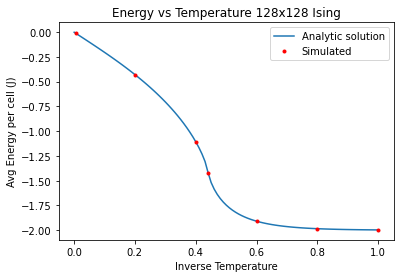

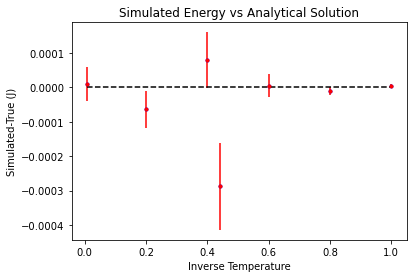

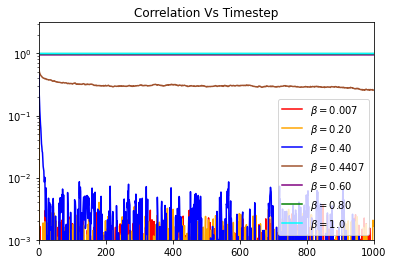

In [33]:
act=cuda.to_device(np.zeros_like(grid,dtype=np.int32))
rngs=create_xoroshiro128p_states(grid.size, seed=1) 
def continuous_tester(grid,B):
    continuous_ising[(4,4), (16,16)](grid,act,100,B,0,rngs,128)

continuous_data=validate(continuous_tester)

0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|27|28|29|30|31|32|33|34|35|36|37|38|39|40|41|42|43|44|45|46|47|48|49|50|51|52|53|54|55|56|57|58|59|60|61|62|63|64|65|66|67|68|69|70|71|72|73|74|75|76|77|78|79|80|81|82|83|84|85|86|87|88|89|90|91|92|93|94|95|96|97|98|99|-0.0140155859375 in 34 seconds
0.0
0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|27|28|29|30|31|32|33|34|35|36|37|38|39|40|41|42|43|44|45|46|47|48|49|50|51|52|53|54|55|56|57|58|59|60|61|62|63|64|65|66|67|68|69|70|71|72|73|74|75|76|77|78|79|80|81|82|83|84|85|86|87|88|89|90|91|92|93|94|95|96|97|98|99|-0.4283000537109375 in 33 seconds
0.0
0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|27|28|29|30|31|32|33|34|35|36|37|38|39|40|41|42|43|44|45|46|47|48|49|50|51|52|53|54|55|56|57|58|59|60|61|62|63|64|65|66|67|68|69|70|71|72|73|74|75|76|77|78|79|80|81|82|83|84|85|86|87|88|89|90|91|92|93|94|95|96|97|98|99|-1.105931484375 in 33 seconds
0.0
0|1|2|3|4|5|6|7|8|9|10|

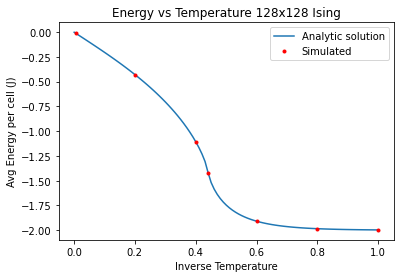

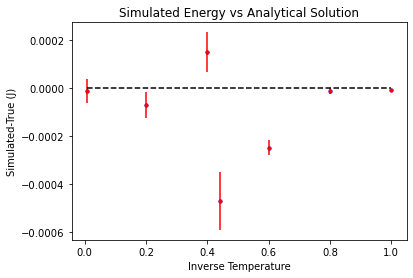

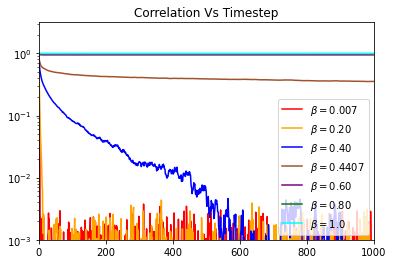

In [32]:
rngs=create_xoroshiro128p_states(grid.size, seed=1) 
def fast_ising_tester(grid,B):
    fast_ising[(8,8), (16,16)](grid,B,0,np.random.randint(2),rngs,128)
    fast_ising[(8,8), (16,16)](grid,B,0,np.random.randint(2),rngs,128)

fast_ising_data=validate(fast_ising_tester)
